The general autoencoder structure was taken from: https://www.tensorflow.org/tutorials/generative/autoencoder and used for this file

This source was used to structure the LSTM model https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from music21 import stream,note

In [16]:
#Read processed songs from file and store in an array
songs_reshaped = pd.read_csv('C:/Users/Amir/Documents/Graduate School/SEP788_789/Project/music_dataset-main/all_songs_m3.txt',delimiter=',',header=None).to_numpy(dtype='float32')

#Reshape songs so that each sample has a length of 64 (4 beats)
songs = songs_reshaped.reshape(-1,64,128).astype('float32')

#Remove notes that occur <100 times to reduce sample size
songs = songs[:,:,30:90]
songs.shape

(17064, 64, 60)

In [4]:
#Delete any sample that may contain only zeros after resizing
zero_images = np.empty(0).astype('int')
for i in range(songs.shape[0]):
    if np.all(songs[i]==0):
        zero_images = np.append(zero_images,i)
songs_nz = np.delete(songs,zero_images,axis=0)

In [5]:
#The latent vector dimension to compress the input into
latent_dim = 128

In [6]:
#Split the dataset into train and test. Keep random state=1 for repeatable results
x_train,x_test = train_test_split(songs_nz, test_size = 0.25, random_state = 1)


In [7]:
#Replaces -1 with 0.5. For use with Relu activation functions.
x_train_norm = np.where(x_train==-1,0.5,x_train)
x_test_norm = np.where(x_test==-1,0.5,x_test)

In [8]:
#Define the encoder model in a function
def encoder():
    model=tf.keras.Sequential()
    model.add(layers.LSTM(500,activation='tanh', input_shape = (64,60), return_sequences = False))
    model.add(layers.Dense(latent_dim))
    return model

# enc = encoder()
# enc.build()
# enc.summary()
# plot_model(enc,show_shapes=True)

In [9]:
#Define the decoder model in a function
def decoder():
    model=tf.keras.Sequential()
    model.add(layers.RepeatVector(64,input_shape=(latent_dim,)))
    model.add(layers.LSTM(500,activation='tanh', return_sequences = True))
    model.add(layers.TimeDistributed(layers.Dense(60)))
    return model

# dec = decoder()
# dec.build()
# dec.summary()
# plot_model(dec,show_shapes=True)


In [10]:
#Define a model class called Autoencoder that is trained
class Autoencoder(Model):
    def __init__(self, latent_dim, encoder, decoder):
        super(Autoencoder,self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
#Call Autoencoder
enc = encoder()
dec = decoder()
autoencoder = Autoencoder(latent_dim,enc,dec)

#Create optimizer and set learning rate
opt = tf.keras.optimizers.Adam(learning_rate = 5e-4)

#Compile model, set loss as mean squared error
autoencoder.compile(optimizer=opt, loss='mse')

In [12]:
#Define an early stop callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode = "min", min_delta = 5e-5, restore_best_weights = True)

#Train the model
autoencoder.fit(x_train, x_train, batch_size = 128, epochs=400,validation_data=(x_test, x_test), callbacks = [early_stop])

Epoch 1/400
33/33 [==============================] - 10s 66ms/step - loss: 0.0366 - val_loss: 0.0323
Epoch 2/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0304 - val_loss: 0.0292
Epoch 3/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0282 - val_loss: 0.0278
Epoch 4/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0272 - val_loss: 0.0272
Epoch 5/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0266 - val_loss: 0.0268
Epoch 6/400
33/33 [==============================] - 1s 38ms/step - loss: 0.0262 - val_loss: 0.0264
Epoch 7/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0259 - val_loss: 0.0262
Epoch 8/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0256 - val_loss: 0.0260
Epoch 9/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0255 - val_loss: 0.0258
Epoch 10/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0253 - val_loss: 0.025

33/33 [==============================] - 1s 35ms/step - loss: 0.0153 - val_loss: 0.0183
Epoch 83/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0152 - val_loss: 0.0182
Epoch 84/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0150 - val_loss: 0.0181
Epoch 85/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0149 - val_loss: 0.0181
Epoch 86/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0150 - val_loss: 0.0181
Epoch 87/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0150 - val_loss: 0.0181
Epoch 88/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0149 - val_loss: 0.0179
Epoch 89/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0147 - val_loss: 0.0180
Epoch 90/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0148 - val_loss: 0.0181
Epoch 91/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0147 - val_loss: 0.0179
Epo

33/33 [==============================] - 1s 36ms/step - loss: 0.0108 - val_loss: 0.0157
Epoch 163/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0108 - val_loss: 0.0158
Epoch 164/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0108 - val_loss: 0.0158
Epoch 165/400
33/33 [==============================] - 1s 38ms/step - loss: 0.0108 - val_loss: 0.0158
Epoch 166/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0107 - val_loss: 0.0157
Epoch 167/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0106 - val_loss: 0.0157
Epoch 168/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0106 - val_loss: 0.0158
Epoch 169/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0107 - val_loss: 0.0157
Epoch 170/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0105 - val_loss: 0.0156
Epoch 171/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0104 - val_loss: 0

33/33 [==============================] - 1s 36ms/step - loss: 0.0063 - val_loss: 0.0120
Epoch 243/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0059 - val_loss: 0.0119
Epoch 244/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0056 - val_loss: 0.0117
Epoch 245/400
33/33 [==============================] - 1s 38ms/step - loss: 0.0054 - val_loss: 0.0116
Epoch 246/400
33/33 [==============================] - 1s 38ms/step - loss: 0.0053 - val_loss: 0.0115
Epoch 247/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0052 - val_loss: 0.0115
Epoch 248/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0052 - val_loss: 0.0120
Epoch 249/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0056 - val_loss: 0.0119
Epoch 250/400
33/33 [==============================] - 1s 38ms/step - loss: 0.0053 - val_loss: 0.0117
Epoch 251/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0051 - val_loss: 0

In [13]:
#Test the models performance by encoding test samples and reconstructing
encoded_sngs = autoencoder.encoder(x_test[0:10]).numpy()
decoded_sngs = autoencoder.decoder(encoded_sngs).numpy()

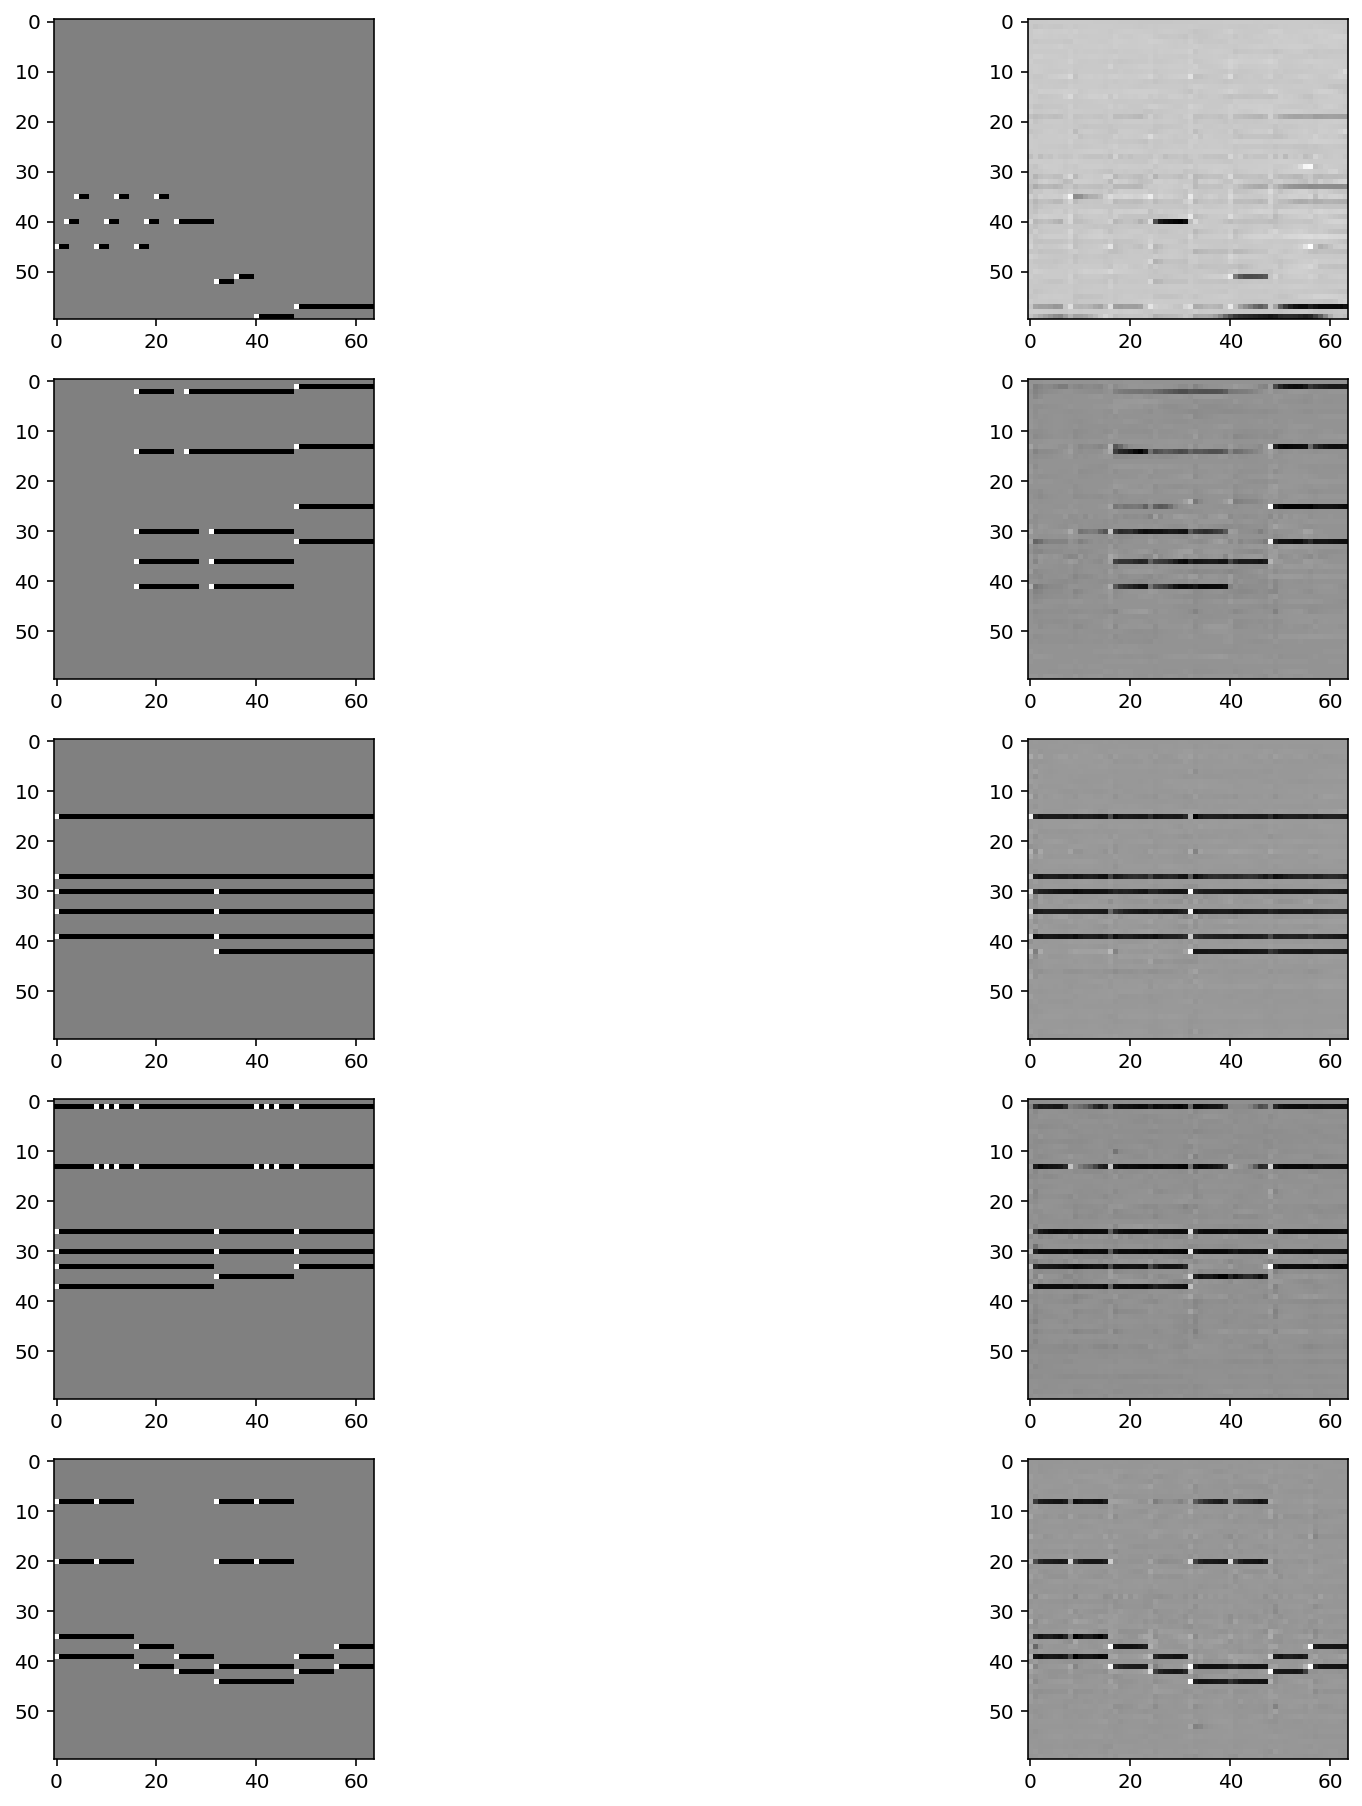

In [15]:
#Show first 5 original vs reconstructed samples
plt.figure(figsize=(16, 16))

for i in range(1,11,2):
    plt.subplot(5,2,i)
    plt.imshow(x_test[int((i-1)/2)].transpose(),cmap='gray')
    plt.subplot(5,2,i+1)
    plt.imshow(decoded_sngs[int((i-1)/2)].transpose(),cmap='gray')
#plt.imshow(decoded_sngs[1].transpose())